In [1]:
from  datetime import datetime, timedelta
import pandas as pd
import pickle
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from downcast import reduce
from numba import jit
import time
import gc
from downcast import reduce
import random
import warnings
from math import ceil
from tqdm import trange
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
warnings.filterwarnings("ignore")

In [2]:
# Large dataset, use 2 methods to save memory
@jit
def reduce_mem_usage(df, verbose=True, method='downcast'):
    start = time.time()
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024 ** 2
    if method == 'downcast':
        df = reduce(df)
    else:
        for col in df.columns:
            col_type = df[col].dtypes
            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction) and time is '.format(end_mem, 100 * (
                    start_mem - end_mem) / start_mem) + str(time.time() - start))
    return df

In [3]:
FIRST_DAY = 846
# use the latest 3 years data only
remove_feature = ['id',
                  'state_id',
                  'store_id',
#                   'item_id',
#                   'dept_id',
                  'cat_id',
                  'date','wm_yr_wk','d','sales']

cat_var = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
cat_var = list(set(cat_var) - set(remove_feature))

In [4]:
grid2_colnm = ['sell_price', 'price_max', 'price_min', 'price_std',
               'price_mean', 'price_norm', 'price_nunique', 'item_nunique',
               'price_momentum', 'price_momentum_m', 'price_momentum_y']

grid3_colnm = ['event_name_1', 'event_type_1', 'event_name_2',
               'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'tm_d', 'tm_w', 'tm_m',
               'tm_y', 'tm_wm', 'tm_dw', 'tm_w_end']

lag_colnm = [ 'sales_lag_28', 'sales_lag_29', 'sales_lag_30',
             'sales_lag_31', 'sales_lag_32', 'sales_lag_33', 'sales_lag_34',
             'sales_lag_35', 'sales_lag_36', 'sales_lag_37', 'sales_lag_38',
             'sales_lag_39', 'sales_lag_40', 'sales_lag_41', 'sales_lag_42',
             
             'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14', 'rolling_std_14',
             'rolling_mean_30', 'rolling_std_30', 'rolling_mean_60',
             'rolling_std_60']

mean_enc_colnm = [
    
    'enc_store_id_dept_id_mean', 'enc_store_id_dept_id_std', 
    'enc_item_id_state_id_mean', 'enc_item_id_state_id_std',

]

In [5]:
########################### Model params
#################################################################################
lgb_params = {
                    'boosting_type': 'gbdt',
                    'objective': 'tweedie',
                    'tweedie_variance_power': 1.1,
                    'metric': 'rmse',
                    'subsample': 0.5,
                    'subsample_freq': 1,
                    'learning_rate': 0.015,
                    'num_leaves': 2**8-1,
                    'min_data_in_leaf': 2**8-1,
                    'feature_fraction': 0.5,
                    'max_bin': 100,
                    'n_estimators': 3000,
                    'boost_from_average': False,
                    'verbose': -1
                } 

In [6]:
cvs = ['public']
STORES = ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']
CATS = ['HOBBIES', 'HOUSEHOLD', 'FOODS']
validation = {
    'cv' : [1885,1913],
    'public' : [1913, 1941],
    'private' : [1941, 1969]
}

In [7]:
%%time

traindata = pd.read_pickle("E:/traindata.pkl").reset_index(drop=True)

Wall time: 13.3 s


In [13]:
%%time

########################### Predict 
#################################################################################

rmsse_bycv = dict()

for cv in cvs:
    print('cv : day', validation[cv])
    
    pred_list = []
    for store in STORES:
        for state in CATS:

            print(store,state, 'start')
            start = time.time()
            grid_df = traindata[(traindata['store_id'] == store) & (traindata['cat_id'] == state)]

            model_var = grid_df.columns[~grid_df.columns.isin(remove_feature)]

            tr_mask = (grid_df['d'] <= validation[cv][0]) & (grid_df['d'] >= FIRST_DAY)
            vl_mask = (grid_df['d'] > validation[cv][0]) & (grid_df['d'] <= validation[cv][1])
            pr_mask = (grid_df['d'] > validation[cv][1])

            train_data = lgb.Dataset(grid_df[tr_mask][model_var], 
                           label=grid_df[tr_mask]['sales'])

            valid_data = lgb.Dataset(grid_df[vl_mask][model_var], 
                               label=grid_df[vl_mask]['sales'])

            m_lgb = lgb.train(lgb_params, train_data, valid_sets = [valid_data, train_data], verbose_eval=50, 
                              num_boost_round = 1000, early_stopping_rounds = 50)
            print('time: ' + str(time.time() - start))
            model_name = 'non_recur_model_'+store+'_'+state+'.bin'
            pickle.dump(m_lgb, open(model_name, 'wb'))
            
            indice_valid = grid_df[vl_mask].index.tolist()
            indice_pred = grid_df[pr_mask].index.tolist()
            prediction_valid = pd.DataFrame({'y_pred': m_lgb.predict(grid_df[vl_mask][model_var])})
            prediction_pred = pd.DataFrame({'y_pred': m_lgb.predict(grid_df[pr_mask][model_var])})
            prediction_valid.index = indice_valid
            prediction_pred.index = indice_pred


            del grid_df, train_data, valid_data, m_lgb, tr_mask, vl_mask
            gc.collect()

            grid_1 = pd.read_pickle('E:/grid_part_1.pkl')
            pd.concat([grid_1.iloc[indice_valid], prediction_valid], axis=1).pivot(index='id', columns='d', values='y_pred').reset_index()\
            .set_index('id').to_csv(f'submission_storeandcat_{store}_{state}_{cv}_valid.csv')
            pd.concat([grid_1.iloc[indice_pred], prediction_pred], axis=1).pivot(index='id', columns='d', values='y_pred') \
            .reset_index().set_index('id').to_csv(f'submission_onlystore_{store}_{cv}_pred.csv')


            del grid_1
            gc.collect()



cv : day [1913, 1941]
CA_1 HOBBIES start
Training until validation scores don't improve for 50 rounds.
[50]	training's rmse: 2.0737	valid_0's rmse: 2.01385
[100]	training's rmse: 1.44856	valid_0's rmse: 1.42129
[150]	training's rmse: 1.13131	valid_0's rmse: 1.11621
[200]	training's rmse: 0.966582	valid_0's rmse: 0.958822
[250]	training's rmse: 0.859437	valid_0's rmse: 0.848465
[300]	training's rmse: 0.815939	valid_0's rmse: 0.808986
[350]	training's rmse: 0.787439	valid_0's rmse: 0.786331
[400]	training's rmse: 0.766326	valid_0's rmse: 0.771998
[450]	training's rmse: 0.750372	valid_0's rmse: 0.763144
[500]	training's rmse: 0.736751	valid_0's rmse: 0.760079
[550]	training's rmse: 0.725595	valid_0's rmse: 0.757576
[600]	training's rmse: 0.714163	valid_0's rmse: 0.755932
[650]	training's rmse: 0.702503	valid_0's rmse: 0.75534
[700]	training's rmse: 0.693361	valid_0's rmse: 0.754604
[750]	training's rmse: 0.683424	valid_0's rmse: 0.754282
[800]	training's rmse: 0.673784	valid_0's rmse: 0.7

[200]	training's rmse: 0.913652	valid_0's rmse: 0.903067
[250]	training's rmse: 0.786205	valid_0's rmse: 0.790372
[300]	training's rmse: 0.736393	valid_0's rmse: 0.745538
[350]	training's rmse: 0.705857	valid_0's rmse: 0.716082
[400]	training's rmse: 0.685057	valid_0's rmse: 0.697467
[450]	training's rmse: 0.668687	valid_0's rmse: 0.684664
[500]	training's rmse: 0.656329	valid_0's rmse: 0.677975
[550]	training's rmse: 0.646307	valid_0's rmse: 0.672471
[600]	training's rmse: 0.637294	valid_0's rmse: 0.668093
[650]	training's rmse: 0.628699	valid_0's rmse: 0.665459
[700]	training's rmse: 0.620854	valid_0's rmse: 0.661312
[750]	training's rmse: 0.613702	valid_0's rmse: 0.660151
[800]	training's rmse: 0.606529	valid_0's rmse: 0.658006
[850]	training's rmse: 0.600234	valid_0's rmse: 0.657461
[900]	training's rmse: 0.594233	valid_0's rmse: 0.657152
[950]	training's rmse: 0.588239	valid_0's rmse: 0.656234
[1000]	training's rmse: 0.582645	valid_0's rmse: 0.656381
[1050]	training's rmse: 0.5770

[600]	training's rmse: 0.638226	valid_0's rmse: 0.416614
[650]	training's rmse: 0.610494	valid_0's rmse: 0.416148
[700]	training's rmse: 0.612613	valid_0's rmse: 0.415254
[750]	training's rmse: 0.5905	valid_0's rmse: 0.414561
[800]	training's rmse: 0.582024	valid_0's rmse: 0.413664
Early stopping, best iteration is:
[777]	training's rmse: 0.578484	valid_0's rmse: 0.414194
time: 93.19651794433594
TX_1 FOODS start
Training until validation scores don't improve for 50 rounds.
[50]	training's rmse: 3.09451	valid_0's rmse: 2.80954
[100]	training's rmse: 2.07558	valid_0's rmse: 1.81132
[150]	training's rmse: 1.58729	valid_0's rmse: 1.34725
[200]	training's rmse: 1.35251	valid_0's rmse: 1.12949
[250]	training's rmse: 1.21381	valid_0's rmse: 1.00301
[300]	training's rmse: 1.14858	valid_0's rmse: 0.959753
[350]	training's rmse: 1.10074	valid_0's rmse: 0.931145
[400]	training's rmse: 1.05988	valid_0's rmse: 0.914904
[450]	training's rmse: 1.02298	valid_0's rmse: 0.905869
[500]	training's rmse: 0

[550]	training's rmse: 1.11004	valid_0's rmse: 1.13611
[600]	training's rmse: 1.08596	valid_0's rmse: 1.13335
[650]	training's rmse: 1.06075	valid_0's rmse: 1.13171
[700]	training's rmse: 1.03897	valid_0's rmse: 1.12919
[750]	training's rmse: 1.02079	valid_0's rmse: 1.12689
[800]	training's rmse: 1.00068	valid_0's rmse: 1.12436
[850]	training's rmse: 0.983375	valid_0's rmse: 1.12446
Early stopping, best iteration is:
[824]	training's rmse: 0.992083	valid_0's rmse: 1.1231
time: 146.41077518463135
WI_1 HOBBIES start
Training until validation scores don't improve for 50 rounds.
[50]	training's rmse: 1.41022	valid_0's rmse: 1.34767
[100]	training's rmse: 0.996839	valid_0's rmse: 0.931733
[150]	training's rmse: 0.793979	valid_0's rmse: 0.74911
[200]	training's rmse: 0.685766	valid_0's rmse: 0.664307
[250]	training's rmse: 0.609143	valid_0's rmse: 0.608177
[300]	training's rmse: 0.577538	valid_0's rmse: 0.590884
[350]	training's rmse: 0.556118	valid_0's rmse: 0.579664
[400]	training's rmse: 

[550]	training's rmse: 0.480836	valid_0's rmse: 0.530113
[600]	training's rmse: 0.471821	valid_0's rmse: 0.527133
[650]	training's rmse: 0.461322	valid_0's rmse: 0.52586
[700]	training's rmse: 0.453585	valid_0's rmse: 0.523128
[750]	training's rmse: 0.445293	valid_0's rmse: 0.523088
[800]	training's rmse: 0.437204	valid_0's rmse: 0.522671
[850]	training's rmse: 0.429134	valid_0's rmse: 0.52296
Early stopping, best iteration is:
[814]	training's rmse: 0.434707	valid_0's rmse: 0.522529
time: 52.35800290107727
WI_3 HOUSEHOLD start
Training until validation scores don't improve for 50 rounds.
[50]	training's rmse: 1.17596	valid_0's rmse: 1.21462
[100]	training's rmse: 0.768	valid_0's rmse: 0.812061
[150]	training's rmse: 0.566939	valid_0's rmse: 0.628002
[200]	training's rmse: 0.456563	valid_0's rmse: 0.53175
[250]	training's rmse: 0.374421	valid_0's rmse: 0.4582
[300]	training's rmse: 0.341979	valid_0's rmse: 0.432504
[350]	training's rmse: 0.320921	valid_0's rmse: 0.41462
[400]	training'

In [19]:
import os
submission_pred = pd.read_csv('D:/HKUST/MAFS6010Z AI in Fintech/project3/sample_submission.csv').set_index('id').iloc[30490:]
submisssion_valid = pd.read_csv('D:/HKUST/MAFS6010Z AI in Fintech/project3/sample_submission.csv').set_index('id').iloc[:30490]
sub_id_valid = pd.DataFrame({'id':submisssion_valid.index.tolist()})
sub_id_pred = pd.DataFrame({'id':submission_pred.index.tolist()})

pri = [a for a in os.listdir() if 'onlystore' in a]
valid = [a for a in pri if 'valid' in a]
pred = [a for a in pri if 'pred' in a]

fcol = [f'F{i}' for i in range(1,29)]
sub_copy = submisssion_valid.copy()
for file in valid:
    temp = pd.read_csv(file).iloc[:,:29]
    temp.columns = ['id']+fcol
    sub_copy += sub_id_valid.merge(temp, how='left', on='id').set_index('id').fillna(0)
sub_copy.columns = fcol

sub_copy1 = submission_pred.copy()
for file in pred:
    temp = pd.read_csv(file).iloc[:,:29]
    temp.columns = ['id']+fcol
    sub_copy1 += sub_id_pred.merge(temp, how='left', on='id').set_index('id').fillna(0)
sub_copy1.columns = fcol

df = pd.concat([sub_copy, sub_copy1])
df.to_csv('E:/submission_nonrecursive_store_cat.csv')

In [20]:
model_path = 'non_recur_model_'+STORES[3]+'_'+CATS[0]+'.bin'
m_lgb = pickle.load(open(model_path, 'rb'))

In [30]:
feature_importance_df = pd.DataFrame()
feats = m_lgb.feature_name()
feature_importance_df['feature'] = feats
feature_importance_df['importance'] = m_lgb.feature_importance()

In [31]:
feature_importance_df

,feature,importance
0,item_id,25356
1,dept_id,986
2,release,4439
3,selling_trend,15538
4,sell_price,4788
5,price_max,3589
6,price_min,3508
7,price_std,4204
8,price_mean,2770
9,price_norm,2581


In [36]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance",
                                                                                                   ascending=False)[
           :20].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

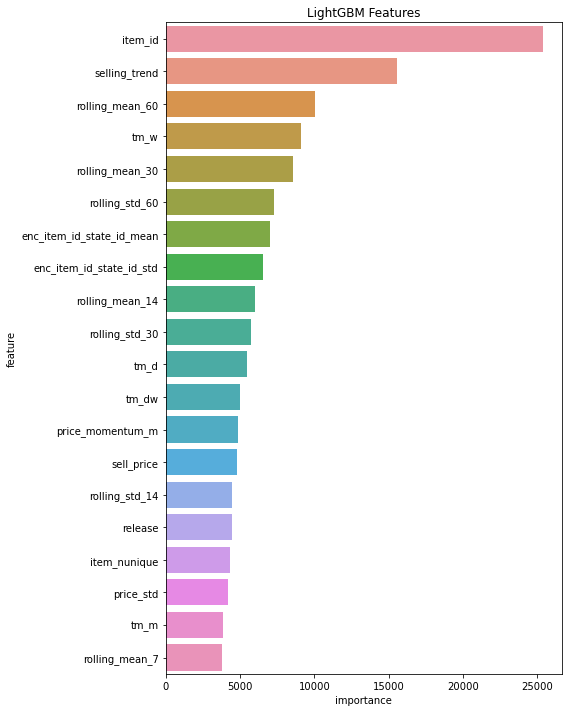

In [37]:
display_importances(feature_importance_df)